In [70]:
import pyodbc
import yfinance as yf
import pandas as pd
from sqlalchemy import create_engine
import datetime
from datetime import date, timedelta

# Verbindungsstring
conn_str = (
    r'Driver=SQL Server;'
    r'Server=.\SQLEXPRESS;'
    r'Database=studienprojekt;'
    r'Trusted_Connection=yes;'
)

# Verbindung zur Datenbank herstellen
cnxn = pyodbc.connect(conn_str)

# SQLAlchemy connectable erstellen
engine = create_engine('mssql+pyodbc://', creator=lambda: cnxn)

# Tabelle prüfen
table_name = "stock_data"  # Name der Zieltabelle
start_date = "2022-07-01"  # Startdatum, ab dem Daten überprüft werden sollen
end_date = "2023-07-01"  # Enddatum, bis zu dem Daten überprüft werden sollen

# Daten aus der Tabelle in einen DataFrame laden
select_query = f"SELECT * FROM {table_name} WHERE date >= ? AND date <= ?"
data = pd.read_sql(select_query, con=engine, params=(start_date, end_date))

# added
data["date"] = data.index
data = data[["date", "open", "high", "low", "close", "volume", "type", "company"]]
data.reset_index(drop=True, inplace=True)

# Verbindung schließen
cnxn.close()

# DataFrame anzeigen
print(data.tail())

     date        open        high         low       close    volume type  \
246   246  186.830002  188.050003  185.229996  185.270004  48088700  ACT   
247   247  185.889999  188.389999  185.669998  188.059998  50730800  ACT   
248   248  187.929993  189.899994  187.600006  189.250000  51216800  ACT   
249   249  189.080002  190.070007  188.940002  189.589996  46347300  ACT   
250   250  191.630005  194.479996  191.259995  193.970001  85069600  ACT   

    company  
246    AAPL  
247    AAPL  
248    AAPL  
249    AAPL  
250    AAPL  


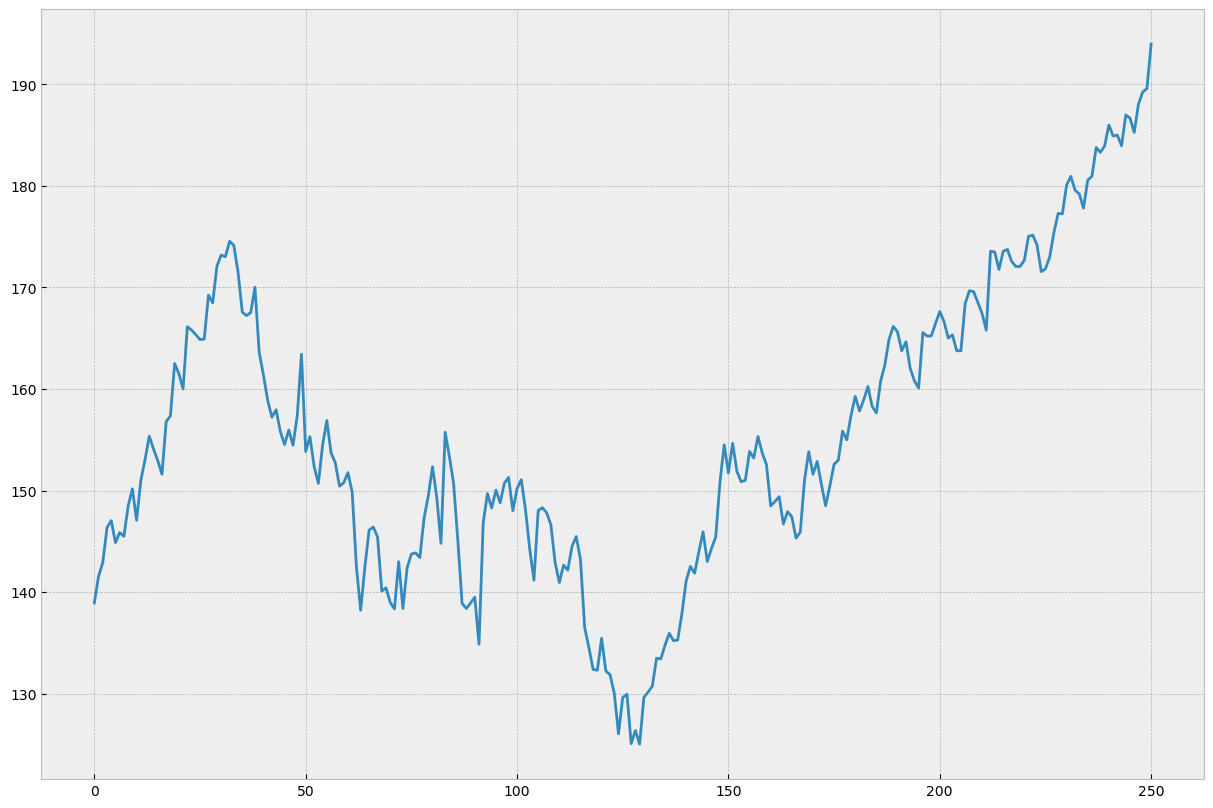

In [71]:
import matplotlib.pyplot as plt
plt.style.use('bmh')
plt.figure(figsize=(15, 10))
plt.plot(data["date"], data["close"])

<Figure size 640x480 with 0 Axes>

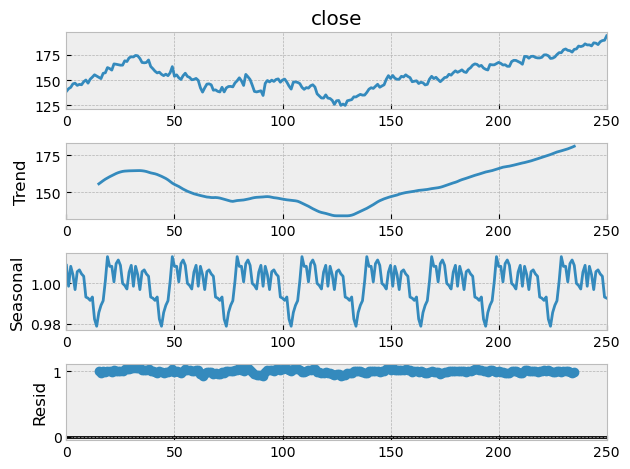

In [72]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data["close"], model='multiplicative', period=30)
fig = plt.figure()  
fig = result.plot()  


<Axes: xlabel='Lag', ylabel='Autocorrelation'>

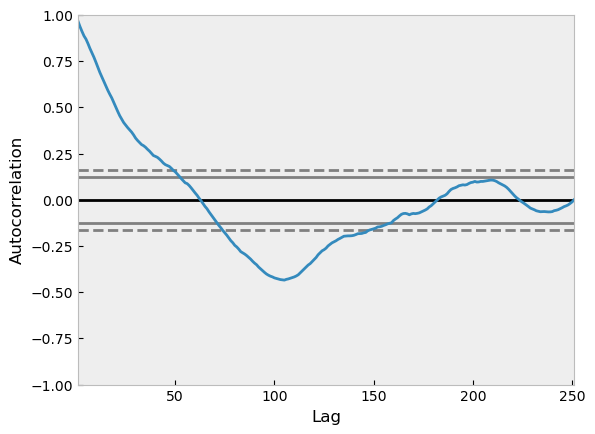

In [73]:
pd.plotting.autocorrelation_plot(data["close"])

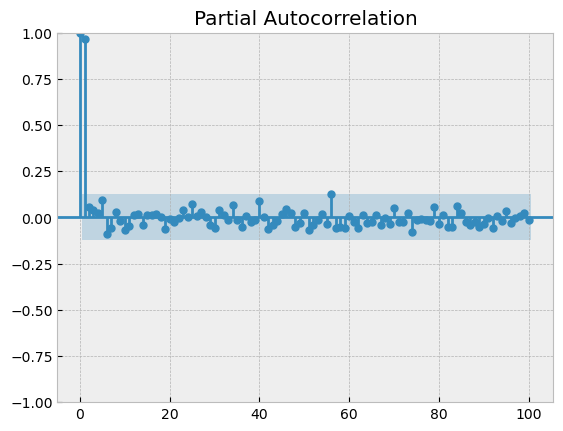

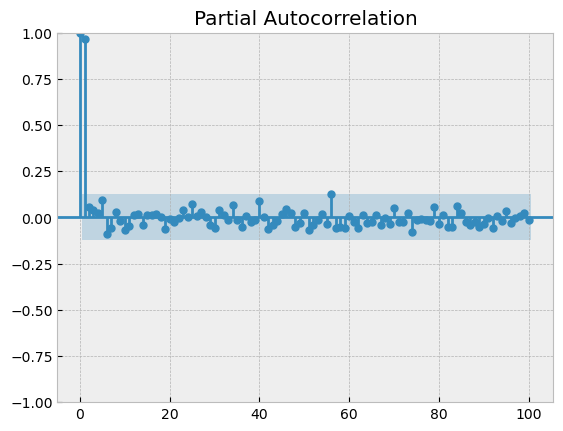

In [74]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data["close"], lags=100, method='ywm')

In [75]:
p, d, q = 5, 1, 2
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(data["close"], order=(p,d,q))
fitted = model.fit()

print(fitted.summary())


                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  251
Model:                 ARIMA(5, 1, 2)   Log Likelihood                -604.830
Date:                Fri, 07 Jul 2023   AIC                           1225.659
Time:                        17:53:55   BIC                           1253.831
Sample:                             0   HQIC                          1236.998
                                - 251                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1212      0.242     -0.501      0.616      -0.595       0.353
ar.L2         -0.6587      0.183     -3.598      0.000      -1.017      -0.300
ar.L3         -0.0242      0.088     -0.275      0.7

In [76]:
predictions = fitted.predict()
print(predictions)

0        0.000000
1      138.929960
2      141.480839
3      142.668123
4      146.122337
          ...    
246    186.497437
247    185.197519
248    187.596649
249    189.536626
250    189.885223
Name: predicted_mean, Length: 251, dtype: float64


In [77]:
import statsmodels.api as sm
import warnings
model=sm.tsa.statespace.SARIMAX(data['close'],
                                order=(p, d, q),
                                seasonal_order=(p, d, q, 12))
model=model.fit()
print(model.summary())

C:\Users\HerbyHerb\.conda\envs\tf_new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                              close   No. Observations:                  251
Model:             SARIMAX(5, 1, 2)x(5, 1, 2, 12)   Log Likelihood                -591.181
Date:                            Fri, 07 Jul 2023   AIC                           1212.362
Time:                                    17:54:28   BIC                           1264.446
Sample:                                         0   HQIC                          1233.353
                                            - 251                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6296      0.320      1.964      0.049       0.001       1.258
ar.L2          0.0679      0.332   

In [78]:
predictions = model.predict(len(data), len(data)+30)
print(predictions)

251    194.574910
252    195.167086
253    195.517340
254    194.086348
255    194.761876
256    194.695117
257    195.935478
258    197.372296
259    196.885451
260    198.167275
261    198.619961
262    197.883586
263    199.208916
264    200.512858
265    200.411875
266    199.255455
267    198.949165
268    199.138710
269    200.335176
270    201.242713
271    201.198258
272    201.213581
273    201.591672
274    200.723656
275    202.005986
276    203.096108
277    202.992585
278    202.856481
279    202.643077
280    202.453503
281    202.994116
Name: predicted_mean, dtype: float64


<Axes: >

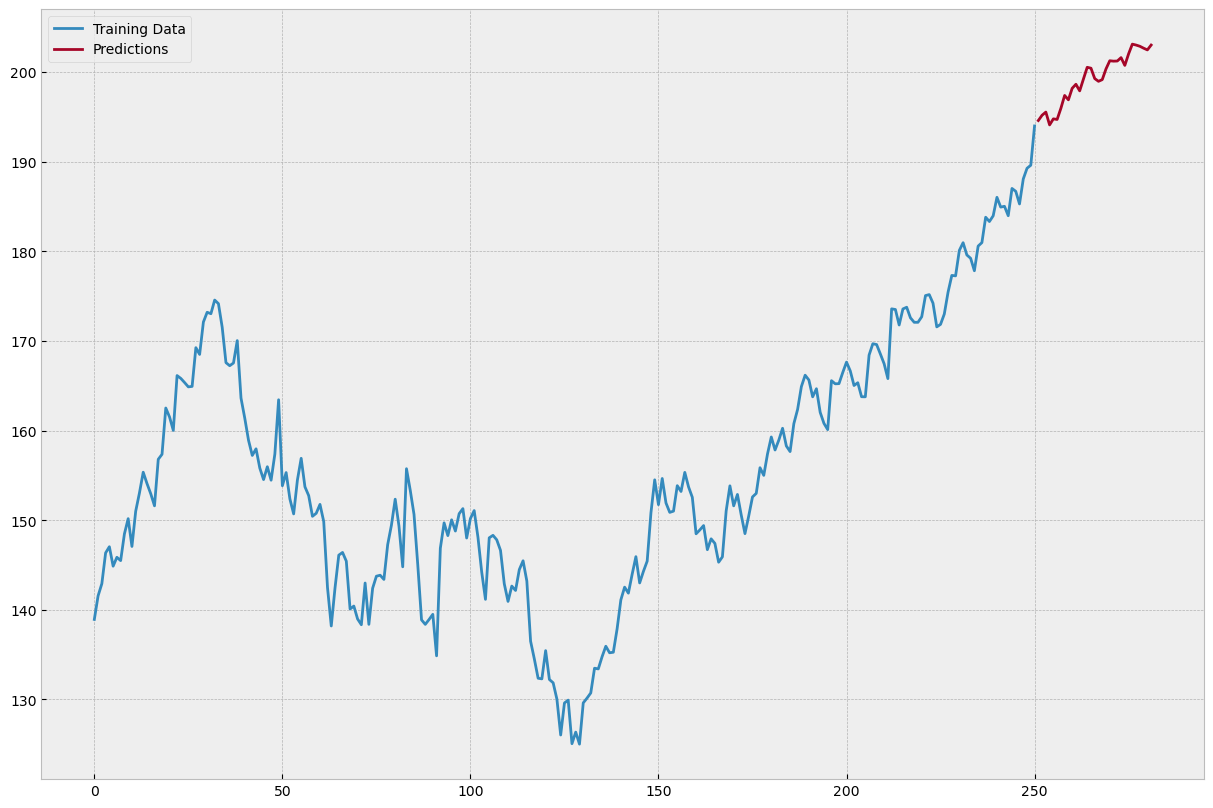

In [79]:
data["close"].plot(legend=True, label="Training Data", figsize=(15, 10))
predictions.plot(legend=True, label="Predictions")

In [65]:
print(data.head())

   date        open        high         low       close    volume type company
0     0  136.039993  139.039993  135.660004  138.929993  71051600  ACT    AAPL
1     1  137.770004  141.610001  136.929993  141.559998  73353800  ACT    AAPL
2     2  141.350006  144.119995  141.080002  142.919998  74064300  ACT    AAPL
3     3  143.289993  146.550003  143.279999  146.350006  66253700  ACT    AAPL
4     4  145.259995  147.550003  145.000000  147.039993  64547800  ACT    AAPL


In [81]:
# Umwandlung der date-Spalte in ein Datetime-Objekt, falls es ein Unix-Timestamp ist
data["date"] = pd.to_datetime(data["date"], unit='s')

# Vorhersagen erstellen
start_point = len(data)
end_point = start_point + 30
predictions = model.predict(start_point, end_point)

# Erstelle Datumsindex für die Vorhersagen
dates = pd.date_range(start=data["date"].iloc[-1] + pd.Timedelta(days=1), periods=30)

# DataFrame für die Vorhersagen erstellen
predictions_df = pd.DataFrame({'date': dates, 'close': predictions})

# Vorhersagen zum ursprünglichen DataFrame hinzufügen
data = pd.concat([data, predictions_df], ignore_index=True)

# DataFrame anzeigen
print(data)


ValueError: array length 30 does not match index length 31

In [66]:

# Ihre bisheriger Code...

# Vorhersagen für die nächsten 30 Tage erhalten
predictions = model.predict(len(data), len(data) + 29)  # 30 Tage Vorhersagen

# Daten für die nächsten 30 Tage generieren
future_dates = pd.date_range(start=data['date'].iloc[-1] + timedelta(days=1), periods=30)

# Ein DataFrame für die Vorhersagen erstellen
df_predictions = pd.DataFrame({
    'date': future_dates,
    'close': predictions
})

# DataFrame erweitern, indem Sie die Vorhersagen anhängen
data_extended = pd.concat([data, df_predictions])

print(data_extended)

TypeError: unsupported operand type(s) for +: 'int' and 'datetime.timedelta'

In [67]:
# Vorhersagen für die nächsten 30 Tage erhalten
predictions = model.predict(len(data), len(data) + 29)  # 30 Tage Vorhersagen

# Daten für die nächsten 30 Tage generieren
data['date'] = pd.to_datetime(data['date'])
future_dates = pd.date_range(start=data['date'].iloc[-1] + timedelta(days=1), periods=30)

# Ein DataFrame für die Vorhersagen erstellen
df_predictions = pd.DataFrame({
    'date': future_dates,
    'close': predictions
})

# DataFrame erweitern, indem Sie die Vorhersagen anhängen
data_extended = pd.concat([data, df_predictions])

print(data_extended)


                             date        open        high         low  \
0   1970-01-01 00:00:00.000000000  136.039993  139.039993  135.660004   
1   1970-01-01 00:00:00.000000001  137.770004  141.610001  136.929993   
2   1970-01-01 00:00:00.000000002  141.350006  144.119995  141.080002   
3   1970-01-01 00:00:00.000000003  143.289993  146.550003  143.279999   
4   1970-01-01 00:00:00.000000004  145.259995  147.550003  145.000000   
..                            ...         ...         ...         ...   
276 1970-01-27 00:00:00.000000250         NaN         NaN         NaN   
277 1970-01-28 00:00:00.000000250         NaN         NaN         NaN   
278 1970-01-29 00:00:00.000000250         NaN         NaN         NaN   
279 1970-01-30 00:00:00.000000250         NaN         NaN         NaN   
280 1970-01-31 00:00:00.000000250         NaN         NaN         NaN   

          close      volume type company  
0    138.929993  71051600.0  ACT    AAPL  
1    141.559998  73353800.0  ACT    A

<Axes: >

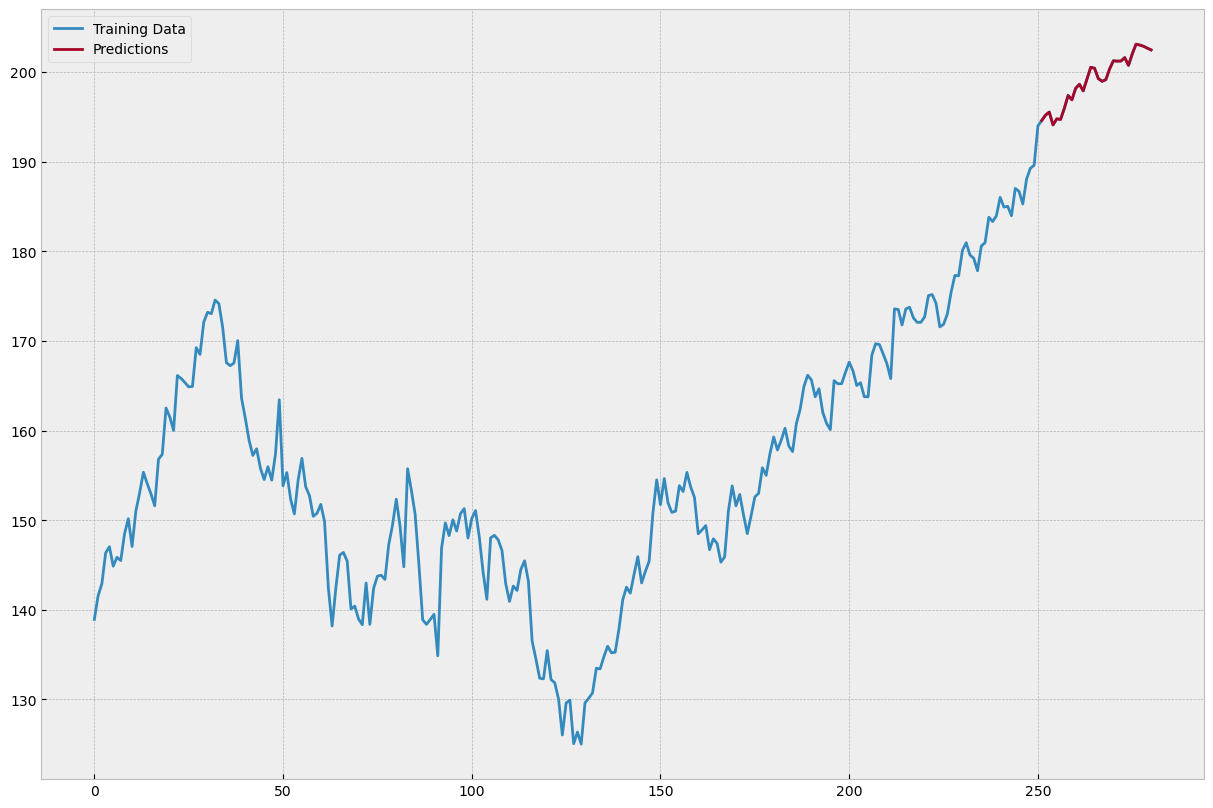

In [68]:
data_extended["close"].plot(legend=True, label="Training Data", figsize=(15, 10))
predictions.plot(legend=True, label="Predictions")

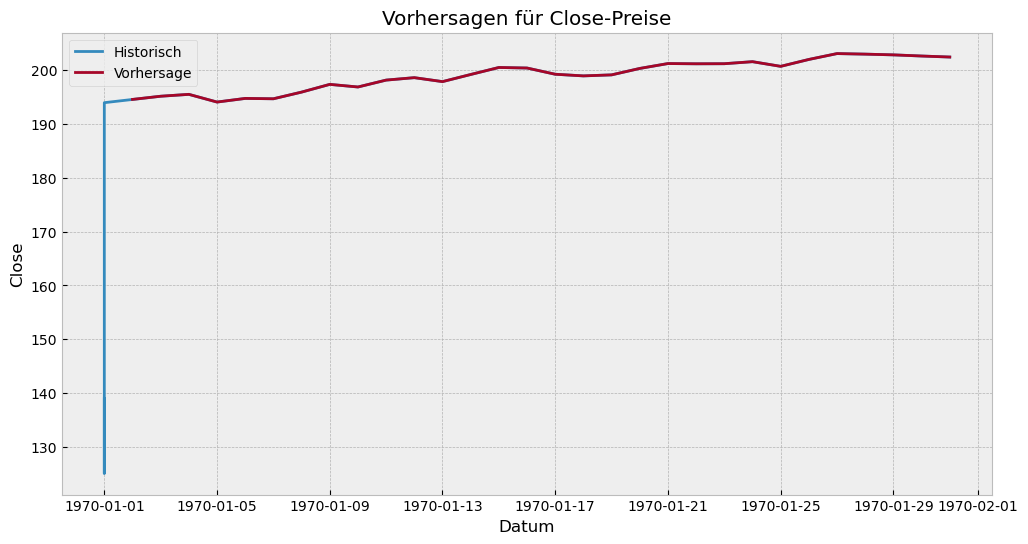

In [69]:
import matplotlib.pyplot as plt

# Ihre bisheriger Code...

# DataFrame erweitern, indem Sie die Vorhersagen anhängen
data_extended = pd.concat([data, df_predictions])

# Plot erstellen
plt.figure(figsize=(12, 6))
plt.plot(data_extended['date'], data_extended['close'], label='Historisch')
plt.plot(data_extended['date'].tail(30), data_extended['close'].tail(30), label='Vorhersage')
plt.xlabel('Datum')
plt.ylabel('Close')
plt.title('Vorhersagen für Close-Preise')
plt.legend()
plt.grid(True)
plt.show()


In [42]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Berechnen Sie die Metriken für die Vorhersagen
mae = mean_absolute_error(data_extended['Close'].tail(30), predictions)
mse = mean_squared_error(data_extended['Close'].tail(30), predictions)
rmse = np.sqrt(mse)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)


MAE: 0.0
MSE: 0.0
RMSE: 0.0
